# MNIST 데이터셋 학습 (to do)
MNIST 데이터셋은0~9까지 총 10개의 label로 이루어진 이미지 분류를 위한 사이즈의 손글씨 데이터셋이다.  
각각의 레이블마다 28×28 크기 이미지인 60,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 70,000개의 28×28 크기의 이미지로 데이터셋이 구성되어 있다.

In [2]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


In [180]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import backend

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

## (1) 데이터셋

In [181]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [182]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

(60000, 28, 28, 1) (60000, 10)


## (2) 모델링

In [193]:
def CNN_Dropout(n_in, n_out):
    # Feature Extraction
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=n_in))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(n_out, activation='softmax'))
    return model

def CNN_Dropout_func(n_in, n_out):
    input = Input(shape=(n_in))
    x = Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=n_in)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=n_in)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(n_out)(x)
    y = Activation('softmax')(x)
    model = Model(inputs = input, outputs = y)
    return model

model=CNN_Dropout_func(n_in, n_out)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_16 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 32)        128 

## (3) 모델의 학습과정 설정

In [194]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.003, decay=1e-5, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## (4) 모델 학습시키기

In [195]:
# 학습과정을 저장할 directory 생성
import os
import datetime

def make_dir(path):
    today = str(datetime.date.today())
    path_date = path+'/'+today
    
    if not os.path.exists(path_date):
        os.makedirs(path_date)
    return path_date

In [196]:
model_path=make_dir('./model')
tensorboard_path=make_dir('./tensorboard')

modelconfig = str(n_in)+'_'+str(n_out)
model_name_path = model_path+'/'+modelconfig+"_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5"

print(model_name_path)
print(tensorboard_path)

./model/2022-12-10/(28, 28, 1)_10_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5
./tensorboard/2022-12-10


In [212]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Coding Time
# Callback list (checkpointer, earlystopper, tb_saver)
checkpointer = ModelCheckpoint(filepath = model_name_path,
                              monitor='val_accuracy',
                              verbose = 0,
                              save_best_only=True)
earlystopper = EarlyStopping(monitor='val_accuracy',
                            patience = 5,
                            verbose=0,
                            mode='auto')
tb_saver = TensorBoard(log_dir=tensorboard_path,
                      write_graph = True)
callback_list=[checkpointer, tb_saver, earlystopper]


# Train (batch : 256, epochs : 50, validation_split : 0.3, verbose : 2, including callback list)
history = model.fit(X_train,Y_train,batch_size=256, epochs=30, validation_split=0.1,verbose=2, callbacks=callback_list)

2022-12-10 21:48:29.005755: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-10 21:48:29.005861: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-10 21:48:29.913540: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-10 21:48:29.913712: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-10 21:48:30.069501: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-10 21:48:30.069535: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 1/30


2022-12-10 21:48:31.047274: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-10 21:48:31.047793: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-10 21:48:31.143709: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 173 callback api events and 172 activity events. 
2022-12-10 21:48:31.155535: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-10 21:48:31.164250: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./tensorboard/2022-12-10/train/plugins/profile/2022_12_10_21_48_31

2022-12-10 21:48:31.170318: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./tensorboard/2022-12-10/train/plugins/profile/2022_12_10_21_48_31/piai-Precision-7920-Tower.trace.json.gz
2022-12-10 21:48:31.179422: I tensorflow/core/profiler/rpc/client/sav

211/211 - 3s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0337 - val_accuracy: 0.9938
Epoch 2/30
211/211 - 2s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0356 - val_accuracy: 0.9945
Epoch 3/30
211/211 - 2s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0328 - val_accuracy: 0.9945
Epoch 4/30
211/211 - 2s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0296 - val_accuracy: 0.9940
Epoch 5/30
211/211 - 2s - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0325 - val_accuracy: 0.9942
Epoch 6/30
211/211 - 2s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0339 - val_accuracy: 0.9933
Epoch 7/30
211/211 - 2s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0334 - val_accuracy: 0.9942


- 모델 학습을 통해 train 모델의 성능이 최대 99.7%, test 모델의 성능이 최대 99.45%인 모델을 생성함.

## (5) 모델 평가하기

In [213]:
print(history.history['loss'])
print(history.history['val_accuracy'])

[0.0035455706529319286, 0.0022004437632858753, 0.0016667826566845179, 0.001273171161301434, 0.001011285581625998, 0.0012123630149289966, 0.001127733150497079]
[0.9938333630561829, 0.9944999814033508, 0.9944999814033508, 0.9940000176429749, 0.9941666722297668, 0.9933333396911621, 0.9941666722297668]


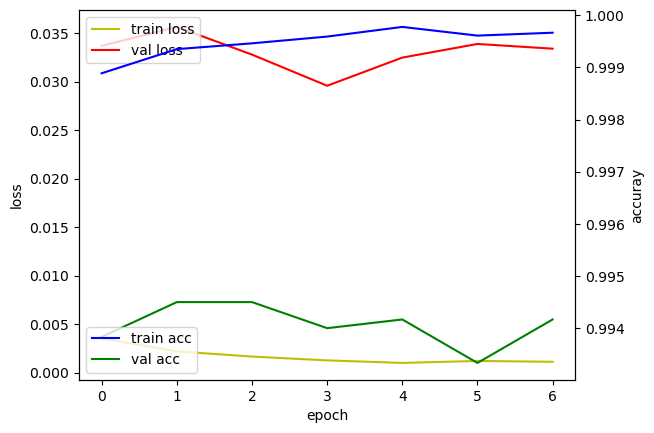

In [214]:
# matplotlib를 이용하여 history 객체 내부에 저장된 값들을 graph로 표현
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 저장하고 싶을 경우
#fig.savefig('final.png')

- History 확인
    - epoch = 0 부터 train 모델과 test 모델의 정확도가 99%대로 들어섰다.
    - 과소적합(underfitting)과 과대적합(overfitting)의 양상은 보이지 않는다.
    - epoch = 1일 때 일반화 성능이 가장 좋은 것으로 보인다.

## (6) 결과 분석하기

## 잘못 분류된 케이스 확인

real label : 2, predict label : 9


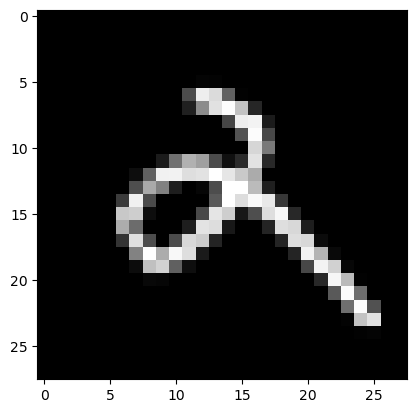

real label : 2, predict label : 7


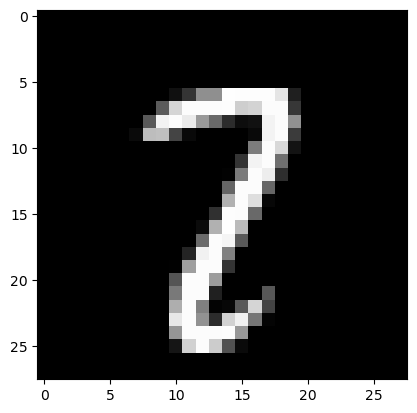

real label : 6, predict label : 0


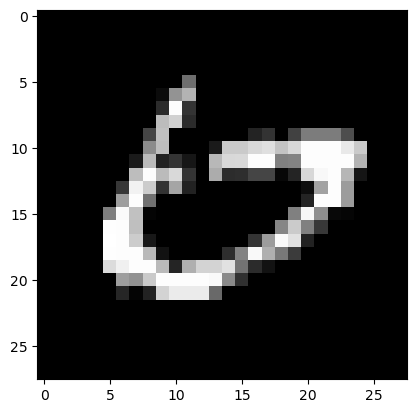

real label : 8, predict label : 2


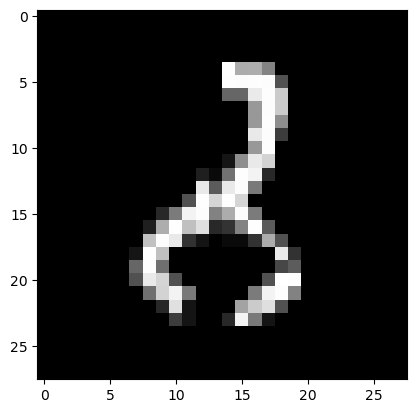

real label : 5, predict label : 3


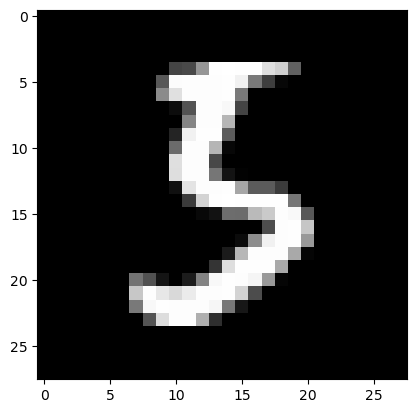

In [216]:
def check_error(Number_Of_Error):
    
    # Coding Time
    cnt = 0 
    for i in range(len(Y_test)):
        test_data = X_test[i].reshape(-1,28,28,1)
        pred_y=model.predict(test_data,verbose=0)
        pred_y = pred_y.argmax()
    
        if pred_y!= list(Y_test[i]).index(1):
            print('real label : {}, predict label : {}'.format(list(Y_test[i]).index(1),pred_y))
            plt.imshow(X_test[i],cmap = 'gray')
            plt.show()
            cnt+=1

        if cnt >= Number_Of_Error:
            break   
            
check_error(5)

- 총 다섯가지의 케이스를 확인했다.
- 기존의 Y_test[i]였던 부분을 list(Y_test[i]).index(1)으로 변경하여 프로그래밍하였다.
- 잘못 읽을 가능성이 높은 숫자에서만 에러가 발생했음을 알 수 있었다.

## 현실적인 최대 정확도 제안

In [217]:
import pandas as pd

# Coding Time
#X_test_flat, batch_size 활용하여 predict된 결과 list 만들기
pred_y = model.predict(X_test, batch_size = 10000, verbose =0)
Y_pred = [x.argmax() for x in pred_y]

# Pandas를 활용하여 confusion matrix 만들기 
data = {'Real':[list(i).index(1) for i in Y_test], 'Predict':Y_pred}
df = pd.DataFrame(data, columns=['Real','Predict'])
conf_mat = pd.crosstab(df['Real'], df['Predict'], rownames=['Real'], colnames=['Predict'])
print(conf_mat)


Predict    0     1     2     3    4    5    6     7    8     9
Real                                                          
0        979     0     0     0    0    0    0     1    0     0
1          0  1132     2     0    0    0    0     1    0     0
2          1     0  1025     0    1    0    0     4    0     1
3          0     0     1  1004    0    2    0     1    1     1
4          0     0     0     0  978    0    0     0    0     4
5          1     0     0     5    0  885    1     0    0     0
6          4     4     1     0    1    3  943     0    2     0
7          0     2     6     0    1    0    0  1017    0     2
8          1     0     2     1    0    0    0     0  968     2
9          0     0     0     0    5    2    0     1    1  1000


- 다음의 confusion matrix를 보면 오분류된 케이스는 9994개의 데이터 중 63개이며 모델의 성능은 99.36%이다.
- 오분류된 데이터를 확인했을 때 숫자의 필기가 명확하지 않다는 점을 고려했을 때 99.36%의 성능은 단일모델로 구현했을 때 최선의 성능이라고 판단됨.

In [215]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 5ms/step - loss: 0.0315 - accuracy: 0.9931
loss : 0.0315, accruracy : 0.9931


- test 데이터로 성능을 확인해본 결과, confusion matrix에서 확인한 것과 같은 성능이 출력됨.

## 개선방향

- 앙상블 기법 활용
    - 앙상블 기법은 대체로 성능을 높이는 대표적인 방법 중 하나다. 
    - 따라서 여러 CNN 모델을 생성하여 도출된 결과를 앙상블할 것을 제안한다.
<br>
<br>
- layer 갯수 및 파라미터 조정
    - 주어진 시간 및 컴퓨터 환경 여건 상, 다양한 시도를 해보지 못했다. 
    - 따라서 더 많은 layer를 두어 계산해볼 것을 제안한다. 
    - 또한 모델 학습과정 설정(compile)과 학습(fit)에 사용하는 파라미터 종류와 시도횟수를 늘려 계산해볼 것을 제안한다.

## 시행착오

- 하나의 모델로 바로 결정하지 않고 실습시간에 다루었던 세가지 모델과 Pytorch까지 전부 활용해보았습니다.
- Pytorch을 이용한 CNN 모델도 성능을 99.3%까지 끌어올렸으나 Keras를 이용한 모델에 더 시간을 많이 투자했기에 Keras 라이브러리 모델로 보고서를 작성했습니다.
- 구현해본 Keras 라이브러리를 활용한 CNN 모델 중 성능이 가장 좋게 나온 Dropout 모델을 이용해 과제를 제출하기로 결정하였고, 파라미터 조정을 통해 성능을 99.4까지 올렸습니다.

In [ ]:
# from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

# n_in = X_train.shape[1:]
# n_out = Y_train.shape[-1]

# def conv_maxpool_layers(n_in):
#     model = Sequential()
#     model.add(Conv2D(16,kernel_size=(3,3),padding='same',activation='relu',input_shape=(n_in)))
#     model.add(Conv2D(32,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Flatten())
#     model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])    
#     return model

# def fc_layers(n_out):
#     model = Sequential()
#     model.add(Dense(units=128,input_shape=(1568,),activation='relu'))
#     model.add(Dense(units=n_out,activation='softmax'))
#     return model

# def CNN_sum(n_in, n_out):    
#     #각 부분 모델
#     feature_extractor = conv_maxpool_layers(n_in)
#     feature_extractor.trainable = True
#     ann_classifier = fc_layers(n_out)
#     ann_classifier.trainable=True
    
#     #두 모델을 합쳐 새로운 모델 정의(Functional Style)
#     x = Input(shape=n_in)
#     feature = feature_extractor(x)
#     y = ann_classifier(feature)
#     model = Model(inputs=x, outputs=y)
    
#     '''
#     Sequential Style
#     model = Sequential()
#     model.add(feature_extractor)
#     model.add(ann_classifier)
#     '''
#     return model

# model = CNN_sum(n_in, n_out)
# model.summary()

In [ ]:
# Pytorch

# maximum_epoch = 70
# learning_rate = 0.0073

# def init_model():
#     global net, loss_fn, optim
#     net = CNN_model().to(device)
#     loss_fn = nn.CrossEntropyLoss()
#     optim = Adam(net.parameters(), lr=learning_rate)
    
# class CNN_model(nn.Module):
#     def __init__(self):
#         super(CNN_model, self).__init__()
#         # 1번 레이어 생성
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(kernel_size = 2, stride = 2),
#         )
        
#         # 2번 레이어 생성
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
        
#         #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
#         self.fc1 = nn.Linear(7 * 7 * 64, 10, bias = True) 
        
#         #가중치 초기화
#         nn.init.xavier_uniform_(self.fc1.weight)

#    #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
#     def forward(self, x):
#         conv_out = self.layer1(x)
#         out = self.layer2(conv_out)
#         out = out.view(out.size(0), -1) # 설명 1
#         out = self.fc1(out)
#         return out, conv_out

# # Model structure check
# Summary(CNN_model().to(device),(1, 28, 28))

- 파라미터 조정도 결코 쉽지 않았습니다.
- loss, optimizer, metrics 전부 다르게 설정하면서 성능을 비교했습니다. learning_rate는 소수점자리를 낮추고 높여가면서 최적점을 찾으려 노력했습니다.

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
#               loss='categorical_crossentropy', 
#               metrics='accuracy')


# model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
#               loss='categorical_crossentropy', 
#               metrics='accuracy')


# from tensorflow.keras.optimizers import RMSprop
# model.compile(loss="categorical_crossentropy",
#               optimizer=RMSprop(lr=0.003,rho=0.9, epsilon=1e-08, decay=0.00001),
#             metrics='binary_accuracy')